<table><tr><td>
  <a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?filepath=demos/embeddings/watch-your-step-cora-demo.ipynb" alt="Open In Binder">
    <img src="https://mybinder.org/badge_logo.svg"/>
  </a>
</td><td>
  <a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/watch-your-step-cora-demo.ipynb" alt="Open In Colab">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
  </a>
</td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  !pip install -q stellargraph[demos]

In [2]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph import datasets

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

## Loading in the data

In [3]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load()

## Creating the model

We create an `AdjacencyPowerGenerator` which loops through the rows of the first `num_powers` of the adjacency matrix.

In [3]:
generator = AdjacencyPowerGenerator(G, num_powers=10)

Next, we use the `WatchYourStep` class to create trainable node embeddings and expected random walks.

In [4]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=64,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.build()

We use the graph log likelihood as our loss function.

In [5]:
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer="adam")

## Training

We now create a training generator and fit our model.

In [6]:
batch_size = 10
train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

history = model.fit(
    train_gen, epochs=40, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size)
)

Train for 270 steps
Epoch 1/40
270/270 [==============================] - 1s 4ms/step - loss: 19297.9218
Epoch 2/40
270/270 [==============================] - 1s 3ms/step - loss: 18853.3897
Epoch 3/40
270/270 [==============================] - 1s 3ms/step - loss: 15683.6990
Epoch 4/40
270/270 [==============================] - 1s 3ms/step - loss: 9749.8504
Epoch 5/40
270/270 [==============================] - 1s 3ms/step - loss: 5570.8296
Epoch 6/40
270/270 [==============================] - 1s 3ms/step - loss: 4074.2995
Epoch 7/40
270/270 [==============================] - 1s 3ms/step - loss: 3620.2262
Epoch 8/40
270/270 [==============================] - 1s 3ms/step - loss: 3457.7274
Epoch 9/40
270/270 [==============================] - 1s 3ms/step - loss: 3383.6839
Epoch 10/40
270/270 [==============================] - 1s 3ms/step - loss: 3340.6625
Epoch 11/40
270/270 [==============================] - 1s 3ms/step - loss: 3311.4318
Epoch 12/40
270/270 [==============================

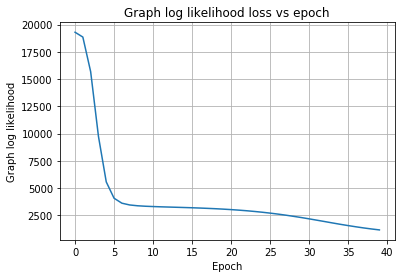

In [7]:
plt.title("Graph log likelihood loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Graph log likelihood")
plt.grid()
plt.plot(history.history["loss"])
plt.show()

## Visualizing Embeddings

Now we use TSNE to visualize the embeddings.

In [8]:
embeddings = wys.embeddings()

In [9]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

nodelist = list(G.nodes())

labels = subjects.loc[nodelist]
target_encoding = OneHotEncoder(sparse=False)
label_vectors = target_encoding.fit_transform(labels.values.reshape(-1, 1))

In [10]:
transform = TSNE

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=nodelist)

emb_transformed["label"] = np.argmax(label_vectors, 1)

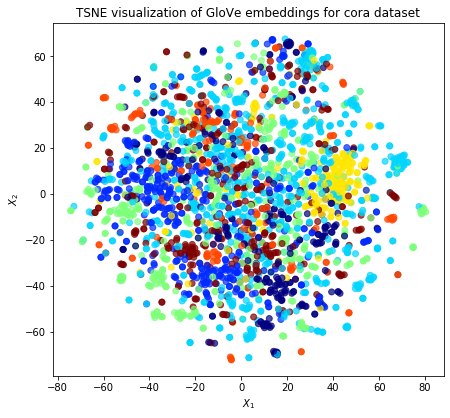

In [11]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GloVe embeddings for cora dataset".format(transform.__name__)
)
plt.show()

# Classification

Cora node classification. Currently this section is especially messy but is here to demonstrate that the node embeddings yield a high classification accuracy.

In [12]:
# choose a random set of training nodes by permuting the labels and taking the first 300.
shuffled_idx = np.random.permutation(label_vectors.shape[0])
train_node_idx = shuffled_idx[:300]
test_node_idx = shuffled_idx[300:]

training_labels = label_vectors.copy()
training_labels[test_node_idx] = 0

In [13]:
d = embeddings.shape[1] // 2

predictions = np.dot(
    np.exp(np.dot(embeddings[:, :d], embeddings[:, d:].transpose())), training_labels
)

np.mean(
    np.argmax(predictions[test_node_idx], 1) == np.argmax(label_vectors[test_node_idx], 1)
)

0.436046511627907